# Рекомендация тарифов / Tariff recommendation

Телеком компания создает два новых тарифа. Необходимо пострлоить классификатор для рекомендации двух новых тарифов клиентам, которые пользуются архивными тарифами. Модель должна показывать **accuracy** не менее 0.75 на тестовой выборке.

-----

The telecom company creates two new tariffs. It is required to build a classifier to recommend two new tariffs to customers who use archived tariffs. The model must show **accuracy** of at least 0.75 on the test set.

In [7]:
# импортируем необходимые для работы библиотеки / libraries import
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

## Изучение данных / EDA

In [12]:
try:
    data = pd.read_csv('/datasets/users_behavior.csv')
except:
    data = pd.read_csv('/home/uladzislau/Documents/Yandex DS/Projects/ML1/users_behavior.csv')

Посмотрим на дынные и их размер

Data and its dimension.

In [13]:
data

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0
...,...,...,...,...,...
3209,122.0,910.98,20.0,35124.90,1
3210,25.0,190.36,0.0,3275.61,0
3211,97.0,634.44,70.0,13974.06,0
3212,64.0,462.32,90.0,31239.78,0


Данные содержат 5 колонок и 3214 наблюдений.

Data contains 5 columns and 3214 observations.

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
calls       3214 non-null float64
minutes     3214 non-null float64
messages    3214 non-null float64
mb_used     3214 non-null float64
is_ultra    3214 non-null int64
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


Вызов метода **info()** показывает, что некоторые переменные находятся в неправильных типах. Колонки **calls** и **messages** имеют тип ***float64***, хотя должны иметь ***int64***. Исправим это.

-----

Calling the **info()** method shows that some variables are in the wrong types. The **calls** and **messages** columns are of type ***float64*** when they should be ***int64***. Let's fix this.

In [15]:
data[['calls', 'messages']] = data[['calls', 'messages']].astype('int')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
calls       3214 non-null int64
minutes     3214 non-null float64
messages    3214 non-null int64
mb_used     3214 non-null float64
is_ultra    3214 non-null int64
dtypes: float64(2), int64(3)
memory usage: 125.7 KB


Посмотрим на описательные статистики, чтобы не было сюрпиризов.

Detect anomalies by looking at descriptive statistics.

In [16]:
data.describe()

,calls,minutes,messages,mb_used,is_ultra
count,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000
mean,63.038892,438.208787,38.281269,17207.673836,0.306472
std,33.236368,234.569872,36.148326,7570.968246,0.461100
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,40.000000,274.575000,9.000000,12491.902500,0.000000
50%,62.000000,430.600000,30.000000,16943.235000,0.000000
75%,82.000000,571.927500,57.000000,21424.700000,1.000000
max,244.000000,1632.060000,224.000000,49745.730000,1.000000


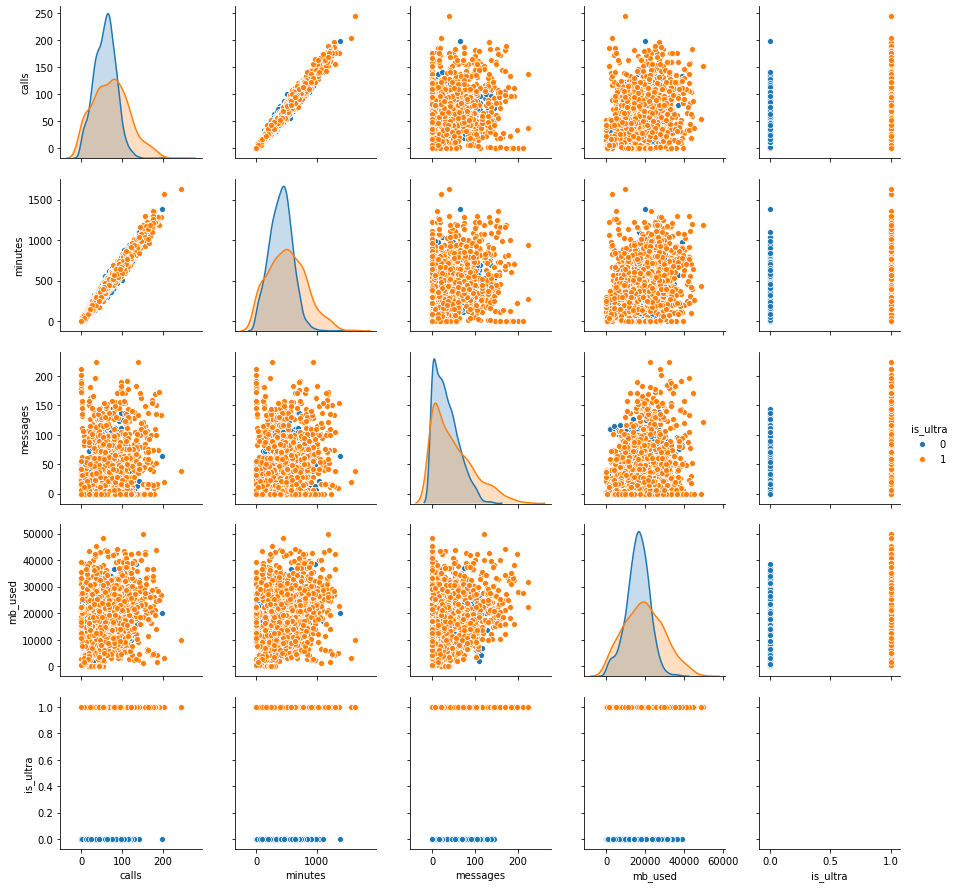

In [20]:
sb.pairplot(data, hue='is_ultra');

## Разбиение данных / Data split

Посмотрим на распределение целевого класса.

Target variable distribution

In [21]:
round(data['is_ultra'].value_counts() / len(data) * 100, 1)

0    69.4
1    30.6
Name: is_ultra, dtype: float64

Видим, что распределение выглядит следующим образом: 70% используют тариф **Смарт**, а 30% - **Ультра**.

We see that the distribution looks like this: 70% use the **Smart** tariff, and 30% - **Ultra**.

Вынесем фичи и целевой класс в отдельные переменные.

Create separate variables for features and target.

In [22]:
features = data.drop('is_ultra', axis=1)
target = data['is_ultra']

In [23]:
features.head()

,calls,minutes,messages,mb_used
0,40,311.90,83,19915.42
1,85,516.75,56,22696.96
2,77,467.66,86,21060.45
3,106,745.53,81,8437.39
4,66,418.74,1,14502.75


In [24]:
target.head()

0    0
1    0
2    0
3    1
4    0
Name: is_ultra, dtype: int64

Переменные созданы верно. Теперь необходимо разбить их на тренировочный, валидационный, и тестовый датасеты. После создания проверим сохраняется ли в них распределение целевого класса. Разбивку будем производить с помощью функции **train_test_split()** из библиотеки ***sklearn***. Разбивку произведем таким образом, чтобы в тренировочном датасете осталось 60% наблюдений. Оставшиеся 40% разобьем на валидационный и тестовый датасеты (50/50).

----

Variables are created correctly. Now we need to split them into training, validation, and test datasets. After creation, we check whether the distribution of the target class is stored in them. We will split using the **train_test_split()** function from the ***sklearn*** library. The breakdown will be done in such a way that 60% of observations remain in the training dataset. The remaining 40% will be divided into validation and test datasets (50/50).

In [25]:
# создадим тренировочный набор данных / training set
train_features, features_rem, train_target, target_rem = train_test_split(features, target, train_size=0.6, random_state=2)

In [26]:
# проверим размер датасетов / sets dimension
print(train_features.shape)
print(train_target.shape)

(1928, 4)
(1928,)


In [27]:
# из оставшихся данных (features_rem, target_rem) сделаем валидационный и тестовый датасеты (поделим пополам)
# validation and test sets
valid_features, test_features, valid_target, test_target = train_test_split(features_rem, target_rem, test_size=0.5, random_state=2)

In [28]:
# проверим размер датасетов / dimension of val and test sets
print(test_features.shape)
print(test_target.shape)
print(valid_features.shape)
print(valid_target.shape)

(643, 4)
(643,)
(643, 4)
(643,)


Проверим соблюдается ли оригинальное распределение целевого класса.

Let's check if the original distribution of the target variable is held.

In [29]:
print(round(train_target.value_counts() / len(train_target) * 100, 1))
print(round(valid_target.value_counts() / len(valid_target) * 100, 1))
print(round(test_target.value_counts() / len(test_target) * 100, 1))

0    69.7
1    30.3
Name: is_ultra, dtype: float64
0    69.4
1    30.6
Name: is_ultra, dtype: float64
0    68.3
1    31.7
Name: is_ultra, dtype: float64


Распределение целевого класса сохраняется во сех данных. Можем переходить к обучению и проверке моделей.

The distribution of the target class is preserved in all data. We can move on to training and testing models.

## Построение и валидация моделей / Model development and validation

Для начала определим какая цель построения модели: классификация или регрессия. Так как мы предсказываем классы (их 2), то мы имеем дело с бинарной классификацией. Для целей классификации подходят такие модели как логистичексая регрессия, дерево решений, и случайный лес. Для начала обучим эти модели на тренировочных данных, используя стандартные параметры, а азтем проверим на валидационном датасете. Для метрики качества моделей будем использовать фуекцию **accuracy_score()**.

----

First, let's define what is the purpose of building a model: classification or regression. Since we are predicting classes (there are 2 of them), we are dealing with a binary classification. Suitable models for classification purposes include logistic regression, decision tree, and random forest. First, we will train these models on training data using standard parameters, and then we will check on the validation dataset. For the model quality metric, we will use the **accuracy_score()** function.

In [30]:
# создадим пустые модели / blank models
lr_model = LogisticRegression(random_state=12345)
dt_model = DecisionTreeClassifier(random_state=12345)
rf_model = RandomForestClassifier(random_state=12345)
print('Модели успешно созданы.')

Модели успешно созданы.


In [31]:
# обучим модели на тренировочных данных / train models
lr_model.fit(train_features, train_target)
dt_model.fit(train_features, train_target)
rf_model.fit(train_features, train_target)
print('Модели успешно обучены.')

Модели успешно обучены.


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [32]:
# предскажем классы на валидационной выборке / predictions on validation set
lr_valid_predictions = lr_model.predict(valid_features)
dt_valid_predictions = dt_model.predict(valid_features)
rf_valid_predictions = rf_model.predict(valid_features)
print('Модели выполнили предсказания.')

Модели выполнили предсказания.


In [33]:
# посчитаем точность предсказаний на валидационной выборке / accuracy on val set
lr_valid_accuracy = accuracy_score(valid_target, lr_valid_predictions)
dt_valid_accuracy = accuracy_score(valid_target, dt_valid_predictions)
rf_valid_accuracy = accuracy_score(valid_target, rf_valid_predictions)

print('Точность предсказаний базовой модели логистической регрессии на валидационной выборке:', lr_valid_accuracy)
print('Точность предсказаний базовой модели дерева решений на валидационной выборке:', dt_valid_accuracy)
print('Точность предсказаний базовой модели случайного леса на валидационной выборке:', rf_valid_accuracy)

Точность предсказаний базовой модели логистической регрессии на валидационной выборке: 0.7013996889580093
Точность предсказаний базовой модели дерева решений на валидационной выборке: 0.7060653188180405
Точность предсказаний базовой модели случайного леса на валидационной выборке: 0.7667185069984448


На валидационной выборке все модели справились примерно одинаково. За пороговое значение возьмем точность равную 0.5. Именно такую точность будет иметь модель которая случайно будет предсказывать класс (вероятность предсказать один из классов - 1/2). Все модели превышают это значение, но самый высокий показатель у модели случайного леса - **0.78**. То есть без каких-либо настроек, модели выдают относительно хорошие результаты.

---

In the validation sample, all models performed approximately the same. For the threshold value, we take the accuracy equal to 0.5. It is this accuracy that a model that will randomly predict a class will have (the probability of predicting one of the classes is 1/2). All models exceed this value, but the Random Forest model has the highest score of **0.78**. That is, without any adjustments, the models give relatively good results.

Теперь оптимизируем гиперпараметры моделей для их улучшения. **Логистическая регрессия** не имеет критических гиперпараметров, поэтому возьмем ее точность на валидационной выборке за **0.73** и на этом шаге рассмотрим только **дерево решений** и **случайны лес**. Среди гиперпараметров **дерева решений** можно оптимизировать максимальную глубину - **max_depth** (сколько ветвлений будет до того как дерево найдет решение), а у **случайного леса** к максимальной глубине еще добавляется гиперпараметр количества деревьев (**n_estimators**), которое будет построено и использовано для усреднения. 

----

Now we optimize the hyperparameters of the models to improve them. **Logistic regression** does not have critical hyperparameters, so let's take its accuracy on the validation set as **0.73** and at this step consider only **decision tree** and **random forest**. Among the **decision tree** hyperparameters, you can optimize the maximum depth - **max_depth** (how many branches there will be before the tree finds a solution), and for a **random forest**, the number of trees hyperparameter (**n_estimators) is added to the maximum depth **), which will be built and used for averaging.

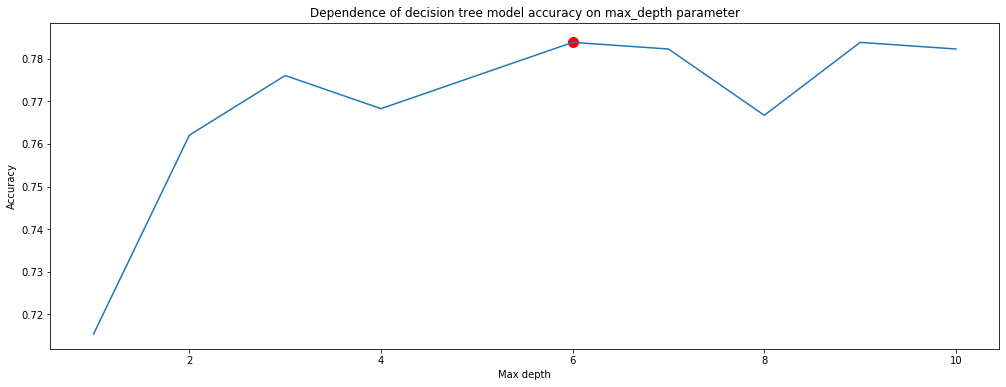

In [34]:
# -------- Дерево решений ----------------------
# decision treee

dt_opt_model = None # для сохранения лучшей модели
dt_opt_accuracy = 0 # для сохранения лучшей точности
dt_accuracies = [] # для всех значений точности
dt_depth = [depth for depth in range(1,11)] # для всех значений глубины

# проверим значения max_depth от 1 до 10
for depth in dt_depth:
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model.fit(train_features, train_target)
    predictions = model.predict(valid_features)
    accuracy = accuracy_score(valid_target, predictions)
    if accuracy > dt_opt_accuracy:
        dt_opt_model = model
        dt_opt_accuracy = accuracy
    dt_accuracies.append(accuracy)

# получим значение максимально точности и 
# соответствующего параметра max_depth
max_accuracy = max(dt_accuracies)
max_accuracy_index = dt_accuracies.index(max_accuracy) + 1

# визуализируем зависимость точности предсказания от глубины дерева
fig, ax = plt.subplots(figsize=(17,6))
sb.lineplot(ax=ax, x=dt_depth, y=dt_accuracies)
plt.scatter(x=max_accuracy_index, y=max_accuracy, color='red', s=100)
plt.title('Dependence of decision tree model accuracy on max_depth parameter')
plt.xlabel('Max depth')
plt.ylabel('Accuracy');

Из графика видно, что **дерево решений** имеет максимальную точность предсказаний (0.78) при значениях параметра **max_depth**, равному 6 или 9 (на графике отмечено красным только 6). Мы возьмем параметр, равный 6, так как при меньших затратах времени на обучение, будем получать тот же результат.

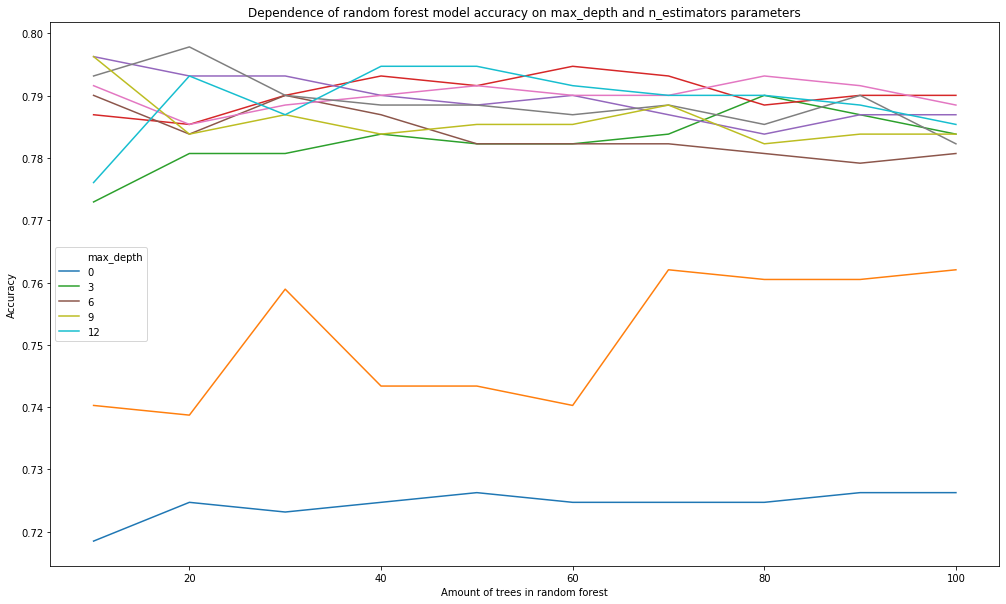

In [35]:
# -------- Случайный лес ----------------------
# random forest

rf_opt_model = None # для сохранения лучшей модели
rf_opt_accuracy = 0 # для сохранения лучшей точности
rf_opt_n_est = 0 # для сохранения лучшего количества деревьев
rf_opt_depth = 0 # для сохранения лучшей глубины
rf_accuracies = {} # для всех значений точности (ключ - max_depth)
rf_depth = [depth for depth in range(1,11)] # для всех значений глубины
rf_n_est = [n for n in range(10,110,10)] # для всех значений количества деревьев

# проверим значения max_depth от 1 до 10
# проверим значения n_estimatirs от 10 до 100 с шагом 10
for depth in rf_depth:
    temp_accuracies = [] # сохраняем точности моделей с различным кол-вом деревьев
    for n in rf_n_est:
        model = RandomForestClassifier(random_state=12345, max_depth=depth, n_estimators=n)
        model.fit(train_features, train_target)
        predictions = model.predict(valid_features)
        accuracy = accuracy_score(valid_target, predictions)
        temp_accuracies.append(accuracy) # присоединим точность для модели с глубиной depth и кол-вом деревьев
        # от 10 до 100 с шагом 10
        if accuracy > rf_opt_accuracy:
            rf_opt_model = model
            rf_opt_accuracy = accuracy
            rf_opt_n_est = n
            rf_opt_depth = depth
    rf_accuracies[depth] = temp_accuracies # присоединим лист с точностями в словарь, где ключ - глубина depth

# создадим дадафрэйм с результатами и применим к нему функцию melt,
# чтобы построить график
rf_model_df = pd.DataFrame(rf_accuracies, index=rf_n_est).melt(value_vars=rf_depth, value_name='accuracy', var_name='max_depth')

# покажем как менется точность случайного леса
# в зависимости от количества деревьев в нем и их глубины
plt.figure(figsize=(17,10))
sb.lineplot(x=rf_n_est*10, y='accuracy', data=rf_model_df, hue='max_depth', palette='tab10')
plt.title('Dependence of random forest model accuracy on max_depth and n_estimators parameters')
plt.xlabel('Amount of trees in random forest')
plt.ylabel('Accuracy');

Из графика можно вынести следующие наблюдения:

- модель случайного леса предсказывает плохо с любым количеством деревьев в нем, если глубина дерева 1 или 2 (точность не выше 0.73 и 0.77 соответственно). В случае глубины дерева равной 1, количество деревьев значительно не влияет на точность. А у модели с глубиной дерева равной 2, количество деревьев влияет на точность. Мы получали точность равную 0.77 на неоптимизированной модели.

- если глубина деревьев 3 и больше, то модели предсказывают значительно лучше.

- самая лучшая модель c параметрами глубины дерева **8** и количеством деревьев **20** выдает точность, равную примерно **0.8**.

-----

The following observations can be made from the graph:

- the random forest model predicts badly with any number of trees in it if the tree depth is 1 or 2 (accuracy is not higher than 0.73 and 0.77 respectively). In the case of tree depth equal to 1, the number of trees does not significantly affect the accuracy. And for a model with a tree depth of 2, the number of trees affects the accuracy. We got an accuracy of 0.77 on the non-optimized model.

- if the depth of the trees is 3 or more, then the models predict much better.

- the best model with tree depth parameters **8** and number of trees **20** gives an accuracy of approximately **0.8**.

### Выводы по исследованию моделей / Conclusion on models' assesment

Мы разделили данные на три части: тренировочный набор, валидационный набор, и тестовый набор. Сначала мы провели обучение трех моделей на обучающей выборке (логистическая регрессия, дерево решений, случайный лес) без настройки гиперпараметров, чтобы знать нужно ли вообще оптимизировать модели. Затем мы проверили эти базовые модели на валидационной выборке. 

Результаты проверки базовых моделей:
- логистическая регрессия - 0.73,
- дерево решений - 0.71,
- случайный лес - 0.78.

Далее мы провели оптимизацию гиперпараметров для дерева решений и случайного леса и проверили точность оптимизированных моделей на валидационной выборке. 

Результаты проверки оптимизированных моделей:
- дерево решений - 0.78 (параметр max_depth=6),
- случайный лес - 0.80 (параметры max_depth=8 и n_estimators=20).

В целом, модели не намного улучшили свои показатели с оптимизацией гиперпараметров, но для проверки моделей на тестовой выборке будем использовать оптимизированную модель случайного леса.

----

We divided the data into three parts: training set, validation set, and test set. We first trained three models on the training set (Logistic Regression, Decision Tree, Random Forest) without hyperparameter tuning to know if the models need to be optimized at all. We then tested these base models against the validation set.

Results of verification of basic models:
- logistic regression - 0.73,
- decision tree - 0.71,
- random forest - 0.78.

Next, we performed hyperparameter optimization for the decision tree and random forest and tested the accuracy of the optimized models on the validation set.

Results of checking the optimized models:
- decision tree - 0.78 (parameter max_depth=6),
- random forest - 0.80 (parameters max_depth=8 and n_estimators=20).

In general, the models did not improve their performance much with hyperparameter optimization, but we will use the optimized random forest model to test the models on the test set.

## Проверка моделей на тестовой выборке / Models assesment on test set

Самый лучший результат на валидационной выборке показала модель случайного леса с параметрами **max_depth=8** и **n_estimators=20**. Проверим как эта модель работает на тестовой выборке.

----

The best result on the validation set was shown by the random forest model with the parameters **max_depth=8** and **n_estimators=20**. Let's check how this model works on a test sample.

In [36]:
# -------- Случайный лес ----------------------
# random forest

rf_test_predictions = rf_opt_model.predict(test_features)
rf_test_accuracy = accuracy_score(test_target, rf_test_predictions)
print('Точность предсказаний ОПТИМИЗИРОВАННОЙ модели случайного леса на ТЕСТОВОЙ выборке:', round(rf_test_accuracy, 2))

Точность предсказаний ОПТИМИЗИРОВАННОЙ модели случайного леса на ТЕСТОВОЙ выборке: 0.83


Результат показывает, что оптимизированная модель работает с данными, которые она никогда не встречала, довольно хорошо.

----

The result shows that the optimized model performs quite well on data it has never encountered.

## Проверка адекватности модели / Model adequacy check

Для проверки адекватности наших моделей мы выбрали модель, которая случайным образом предсказывает классы. Точность такой модели равна 0.5, так как она предсказывает один из двух классов с вероятностью 1/2. При обучении и тестировании базовых моделей (без настройки гипрепараметров) на **валидационной выборке** мы видели, что модели выдаю точности, намного большие, чем пороговое значение (0.73, 0.71, и 0.78 соответственно). Оптимизация параметров дерева решений и случайного леса немного увеличила точности этих моделей (0.78 и 0.8 соответственно) на **валидационной выборке**. Это значит, что модели действительно различают в данных закономерности, которые говорят в пользу того или иного тарифа. Оптимизированная модель случайного леса на **тестовой выборке** по сравнению со случайной моделью работает в разы лучше - фактор случайности отсутствует и модель находит паттерны в данных (0.83 vs 0.5)

Проведем другую проверку. Пусть есть модель, которая предсказывает самый распространенный в данных класс. В нашем случае, модель всегда предсказывала бы класс 0 (пользуется тарифом Смарт). Тогда бы точность нашей модели была бы 2229/3214 = 0.69. Можем сделать вывод, что базовые модели логистической регрессии и дерева решений на **валидационной выборке** не сильно отличаются от простого призначения самого распространенного класса (0.73 vs 0.69 и 0.71 vs 0.69), в то время как базовая модель случайного леса показывает на **валидационной выборке** результаты лучше (0.78 vs 0.69). Оптимизация параметров дерева решений и случайного леса увеличила точность этих моделей (0.78 vs 0.69 и 0.8 vs 0.69). Оптимизированная модель случайного леса на **тестовой выборке** по сравнению c назначением распространенного класса, присваивает класс, основываясь на закономерностях в данных (0.83 vs 0.69).

Обученная и оптимизированная нами модель случайного леса прошла проверку на адекватность двумя способами: сравнение со случайной моделью и моделью, пердсказывающей самый распространенный класс.

----

To test the adequacy of our models, we chose a model that randomly predicts classes. The accuracy of such a model is 0.5, since it predicts one of the two classes with a probability of 1/2. When training and testing the base models (without hyperparameter tuning) on the **validation set**, we have seen that the models produce accuracies much greater than the threshold value (0.73, 0.71, and 0.78 respectively). Optimizing the parameters of the decision tree and random forest slightly increased the accuracy of these models (0.78 and 0.8 respectively) on the **validation set**. This means that the models really distinguish patterns in the data that speak in favor of one or another tariff. The optimized random forest model on the **test set** compared to the random model works many times better - there is no random factor and the model finds patterns in the data (0.83 vs 0.5)

Let's do another check. Let there be a model that predicts the most common class in the data. In our case, the model would always predict class 0 (using the Smart tariff). Then the accuracy of our model would be 2229/3214 = 0.69. We can conclude that the underlying logistic regression and decision tree models on the **validation set** do not differ much from the simple recognition of the most common class (0.73 vs 0.69 and 0.71 vs 0.69), while the underlying random forest model shows ** validation set** results are better (0.78 vs 0.69). Optimizing the parameters of the decision tree and random forest increased the accuracy of these models (0.78 vs 0.69 and 0.8 vs 0.69). Optimized Random Forest Model on **Test Set** vs. Common Class Assignment, assigns a class based on patterns in the data (0.83 vs 0.69).

The random forest model trained and optimized by us was tested for adequacy in two ways: comparison with a random model and a model predicting the most common class.

## Общий вывод / Conclusion

В данном проекте нашей целью было построить разные модели классификации тарифов телеком-оператора по данным пользователей (количество звонков, продолжительность звонков, количество смс, испльзованные интернет-трафик). После знакомства с данными, мы разбили их на три части: тренировочный, валидационный, и тестовый наборы.

Для классификации обучили и оптимизировали гиперпараметры 3ех моделей: логистической регрессии, дерева решений, и случайного леса. После обучения модели были проверены на валидационной выборке. Самую выосокую точность показала модель случайного леса с гиперпараметрами max_depth=8 и n_estimators=20 - доля точно предсказанных классов равна **0.8**. Эту модель использовали для проверки на тестовой выборке. На ней модель показала точность, равную **0.83**.

Проверка нашей модели на адекватность путем сравнения с моделями, которые либо случайно предсказывают класс, либо предсказывают константу (например, самый распространенный класс), показала, что модель случайного леса отлично справляется со своей задачей и находит закономерности в данных, которые могут указать на то, какой тариф подойдет человеку.

----

In this project, our goal was to build different models for classifying the tariffs of a telecom operator according to user data (number of calls, call duration, number of SMS, Internet traffic used). After getting acquainted with the data, we divided them into three parts: training, validation, and test sets.

For classification, hyperparameters of 3 models were trained and optimized: logistic regression, decision tree, and random forest. After training, the models were tested on the validation set. The highest accuracy was shown by the random forest model with hyperparameters max_depth=8 and n_estimators=20 - the proportion of accurately predicted classes is **0.8**. This model was used to test on a test sample. On it, the model showed an accuracy equal to **0.83**.

Testing our model for adequacy by comparing it to models that either randomly predict a class or predict a constant (for example, the most common class) showed that the random forest model does an excellent job and finds patterns in the data that can indicate what is the rate for the person.